In [ ]:
import pandas as pd
df = pd.read_csv('kddcup.data_10_percent.gz', header=None)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
import matplotlib.pyplot as plt

# **plotiing of graph **

here we are plotting the graph for the data set so that we can detect the anomalys present in the dataset

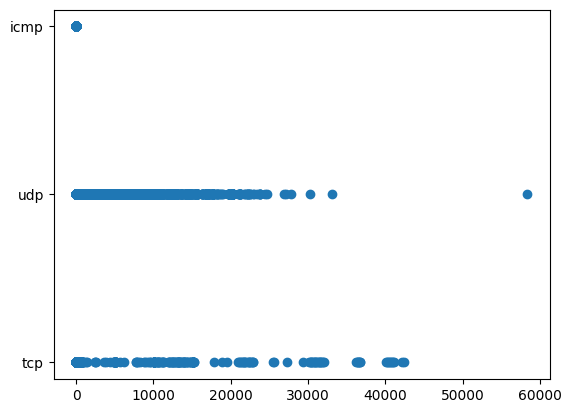

In [ ]:
plt.scatter(df.iloc[:,0],df.iloc[:,1])

### results of plotting the graph
now we can see from the graph the following things obtained :
# **1)UDP with very high X values (~60,000):**

There’s a single or very few data points far to the right (high X value) in the udp group.

These could be outliers or anomalous UDP connections.

# **2)Sparse ICMP Points:**

Only one ICMP data point is shown.

Depending on the dataset size, this rarity could be unusual and may require deeper inspection.

# 3)Gaps in TCP data: **bold text**

If the TCP protocol shows consistent clustering but a few points are distant or isolated, those might also be anomalies.

In [ ]:
from sklearn.ensemble import IsolationForest

# importing the isolation forest model from sklearn

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming df is your original DataFrame

# Step 1: Encode categorical (non-numeric) columns
df_encoded = df.copy()

# Automatically find and label encode all object (string) columns
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Step 2: Fit Isolation Forest on the encoded DataFrame
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(df_encoded)

# Step 3: Predict anomalies
predictions = clf.predict(df_encoded)

# Step 4: Add predictions back to the DataFrame
df_encoded['anomaly'] = predictions

# Optional: See how many anomalies were detected
print(df_encoded['anomaly'].value_counts())


anomaly
 1    469320
-1     24701
Name: count, dtype: int64


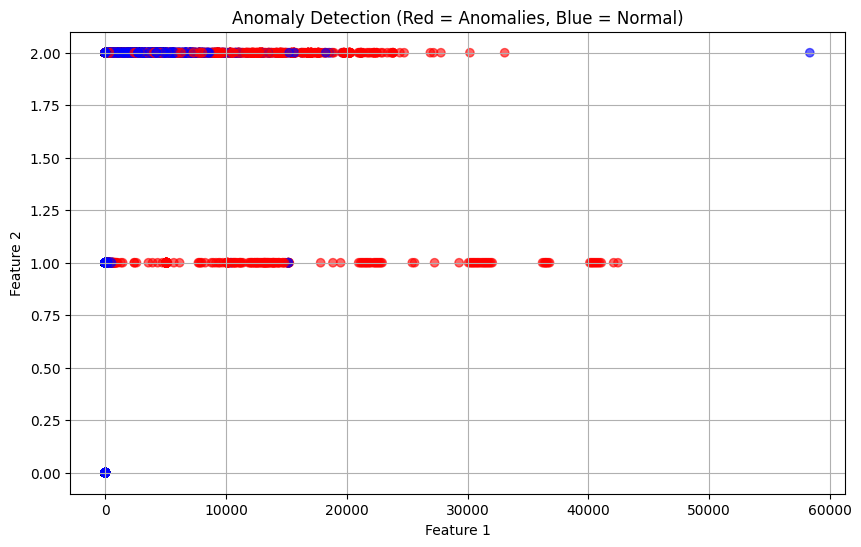

In [ ]:
import matplotlib.pyplot as plt

# Color map: red for anomaly (-1), blue for normal (1)
colors = df_encoded['anomaly'].map({1: 'blue', -1: 'red'})

# Plot first two features — adjust as needed
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded.iloc[:, 0], df_encoded.iloc[:, 1], c=colors, alpha=0.6)
plt.title("Anomaly Detection (Red = Anomalies, Blue = Normal)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [ ]:
print(df.columns)

df.rename(columns={41: 'label'}, inplace=True)


Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41],
      dtype='int64')


In [ ]:
print(df['label'].unique())


['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


In [ ]:
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'normal.' else -1)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(df['binary_label'], predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(df['binary_label'], predictions))


Accuracy: 0.21386337827744165
Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.04      0.08    396743
           1       0.19      0.92      0.31     97278

    accuracy                           0.21    494021
   macro avg       0.43      0.48      0.20    494021
weighted avg       0.58      0.21      0.12    494021



In [ ]:

from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(['anomaly'], axis=1))

# Build autoencoder
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on normal data only
normal_data = X_scaled[df['binary_label'] == 1]
autoencoder.fit(normal_data, normal_data, epochs=10, batch_size=256, shuffle=True, verbose=1)

# Compute reconstruction loss
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.square(X_scaled - reconstructions), axis=1)
threshold = np.percentile(mse, 95)
pred_auto = np.where(mse < threshold, 1, -1)

# Evaluation
from sklearn.metrics import classification_report
print("Autoencoder Classification Report:")
print(classification_report(df['binary_label'], pred_auto))


Epoch 1/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1153
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0084
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6791e-04
Epoch 9/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6004e-04
Epoch 10/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7415e-04
15439/15439 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Autoencoder Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.06      0.12    396743
           1       0.21      1.00      0.34     97278

    accuracy                           0.25    494021
   macro avg      

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(name, true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, pos_label=-1)
    rec = recall_score(true_labels, predictions, pos_label=-1)
    f1 = f1_score(true_labels, predictions, pos_label=-1)
    return [name, acc, prec, rec, f1]

results = []
results.append(evaluate_model("Isolation Forest", df['binary_label'], predictions))
results.append(evaluate_model("Autoencoder", df['binary_label'], pred_auto))

import pandas as pd
comparison_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(comparison_df)


              Model  Accuracy  Precision    Recall  F1-Score
0  Isolation Forest  0.213863   0.669528  0.041684  0.078483
1       Autoencoder  0.246909   0.999960  0.062259  0.117221


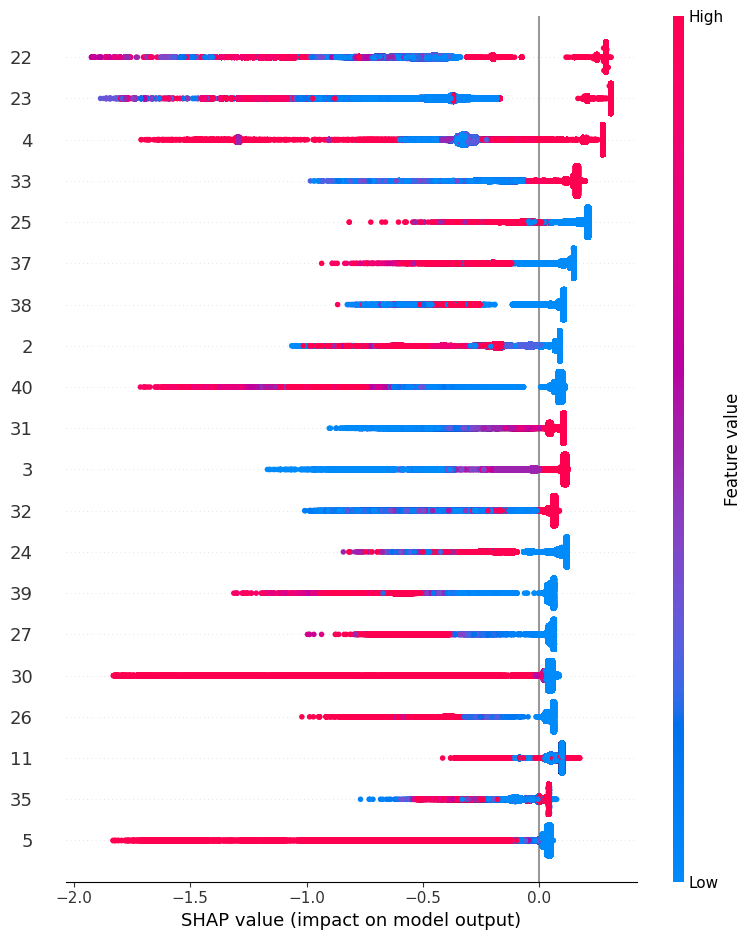

In [ ]:

import shap

# SHAP for tree-based models
explainer = shap.Explainer(clf)
shap_values = explainer(df_encoded.drop(['anomaly'], axis=1))

# SHAP summary plot
shap.summary_plot(shap_values, df_encoded.drop(['anomaly'], axis=1))


In [ ]:

import matplotlib.pyplot as plt

# Show anomaly distribution by attack type
attack_counts = df[df['binary_label'] == -1]['label'].value_counts()
attack_counts.plot(kind='bar', figsize=(12, 5), title='Anomaly Types Detected (Attack Distribution)', color='red')
plt.ylabel("Number of Detected Attacks")
plt.grid(True)
plt.show()
